# Despliegue

En el presente notebook podras encontrar una implementación de TensorFlow para la clasificación de digitos manuscritos. Esta tiene como fin generar un modelo para su despliegue dentro de un contenedor docker. Esta vez, usaremos el dataset MNIST desde la librería TensorFlow Datasets, el cual es muy usado por la comunidad para primeros experimentos de Deep Learning y Machine Learning para reconocimiento de imágenes.


In [7]:
# Importar librerías
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,log_loss, confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay

import tensorflow as tf
import tensorflow_datasets as tfds

/Users/edwinsalcedo/anaconda3/envs/mlops/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
training_set, dataset_info_train = tfds.load('mnist', split = 'train', as_supervised = True, with_info = True)
testing_set, dataset_info_test = tfds.load('mnist', split = 'test', as_supervised = True, with_info = True)

2025-05-20 20:01:12.724275: W external/local_xla/xla/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Could not resolve hostname', error details: Could not resolve host: metadata.google.internal".


Dl Completed...: 100%|███████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68 file/s]

Dataset mnist downloaded and prepared to /Users/edwinsalcedo/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [25]:
# Ver caracteristicas del dataset
num_classes = dataset_info_train.features['label'].num_classes
print('Existen',num_classes,'categorías en el dataset')

num_training_examples = dataset_info_train.splits['train'].num_examples
print('Existen',num_training_examples, 'imágenes en el conjunto de entrenamiento')

Existen 10 categorías en el dataset
Existen 60000 imágenes en el conjunto de entrenamiento


In [26]:
def normalize(image, label):
    # Convertir la imagen a float32 para usar valores decimales en el tensor
    image = tf.cast(image, tf.float32)
    # Dividir el tensor entre el nivel de intensidad mas alto en la imagen
    image /= 255

    return image, label

def prepare_subset(subset, batch_size):
  # Almacenar el subconjunto de datos de entrenamiento en cache
  batches = subset.cache()
  # Barajar (intercambiar el orden) el subconjunto. Esta mezcla aleatoria se
  # hara antes de procesar el dataset con el modelo. Podemos definir el comportamiento
  # de esta función (cuan barajados estaran los lotes) definiendo un valor igual o
  # menor al tamaño del subconjunto. Para realizar un barajamiento completo con
  # respecto a todo el subconjunto, solo basta pasar como parametro el tamaño completo
  # del subconjunto. En este caso tomaremos en cuenta a la cuarta parte.
  batches = batches.shuffle(num_training_examples//4)
  # Dividir al subconjunto en lotes y aplicarles la función normalize()
  # prefetch(1) convierte a esta tarea en asincrona, por lo que seguira su ejecución
  # sin paralizar toda la tarea de cargado de datos. De esta manera, las tareas de
  # procesamiento de datos se llevaran a cabo en paralelo
  batches = batches.batch(batch_size).map(normalize).prefetch(1)

  return batches

# Primer hiperparametro. Tamaño de lote.
BATCH_SIZE = 64

training_batches = prepare_subset(training_set, BATCH_SIZE)
testing_batches = prepare_subset(testing_set, BATCH_SIZE)

# Mostrar el contenido de un batch
for image_batch, label_batch in training_batches.take(1):
    print('dtype:', image_batch.dtype)
    print('shape:', image_batch.shape)
    image_batch

    print('Etiquetas:', label_batch)

2025-05-20 20:35:31.277721: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608


dtype: <dtype: 'float32'>
shape: (64, 28, 28, 1)
Etiquetas: tf.Tensor(
[2 5 9 9 8 5 6 6 2 7 9 7 8 9 6 9 5 8 0 3 1 8 1 8 6 6 8 3 6 2 8 7 8 6 5 2 5
 7 1 2 3 7 0 2 0 6 2 0 5 7 5 5 1 5 4 6 0 2 2 4 6 2 3 7], shape=(64,), dtype=int64)


2025-05-20 20:35:31.491309: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-20 20:35:31.493006: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-20 20:35:31.498710: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

In [27]:
# Crear red neuronal
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = (28,28,1)),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(64, activation = 'relu'),
        tf.keras.layers.Dense(10, activation = 'softmax')
])

# Mostrar resumen del modelo
model.summary()

/Users/edwinsalcedo/anaconda3/envs/mlops/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
# Inicializar los pesos y bias en el modelo
model.build((None, 28, 28, 1))

# Limpiar los datos en la RAM  que hubiesen sido guardados en entrenamientos anteriores
tf.keras.backend.clear_session()

In [29]:
from sklearn.datasets import fetch_openml
# Descargar dataset mnist
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [30]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
for image_batch, label_batch in training_batches.take(1):
    loss, accuracy = model.evaluate(image_batch, label_batch)

print('\nPerdida (Loss) antes del entrenamiento: {:,.3f}'.format(loss))
print('Precisión antes del entrenamiento: {:.3%}'.format(accuracy))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1042 - loss: 2.2910 

Perdida (Loss) antes del entrenamiento: 2.313
Precisión antes del entrenamiento: 9.375%


2025-05-20 20:49:50.155544: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-20 20:49:50.157789: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-20 20:49:50.254432: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence

In [32]:
# Entrenar modelo
EPOCHS = 10

history = model.fit(training_batches, epochs = EPOCHS)

Epoch 1/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8542 - loss: 0.5014
Epoch 2/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9632 - loss: 0.1232
Epoch 3/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9751 - loss: 0.0808
Epoch 4/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9814 - loss: 0.0617
Epoch 5/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9856 - loss: 0.0467
Epoch 6/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9888 - loss: 0.0364
Epoch 7/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9899 - loss: 0.0318
Epoch 8/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9921 - loss: 0.0252
Epoch 9/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9927 - loss: 0.0219
Epoch 10/10
938/938 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9939 - loss: 0.0186


In [33]:
# Mostrar las métricas recolectadas durante cada época
print(history.params)
print(print(history.history['loss']))
print(print(history.history['accuracy']))

{'verbose': 'auto', 'epochs': 10, 'steps': 938}
[0.275433212518692, 0.11383441835641861, 0.07729622721672058, 0.05993761494755745, 0.04664028063416481, 0.03645765036344528, 0.029948456212878227, 0.02446831576526165, 0.02159309573471546, 0.018024666234850883]
None
[0.9197666645050049, 0.9659000039100647, 0.9760500192642212, 0.9815666675567627, 0.9855166673660278, 0.9881666898727417, 0.9906166791915894, 0.9919833540916443, 0.9927166700363159, 0.9939500093460083]
None


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


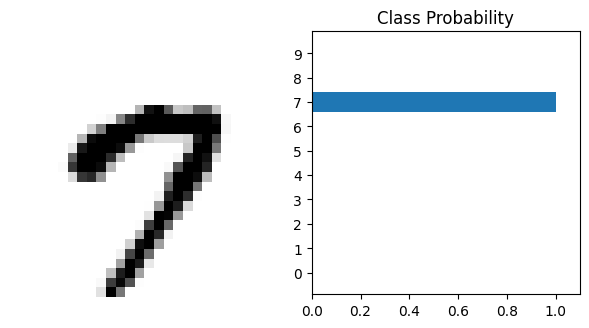

In [34]:
# Realizar inferencia con una instancia
for image_batch, label_batch in testing_batches.take(1):
  # Predecir resultados con un batch
  ps = model.predict(image_batch)
  # Recuperar la primera imagen
  first_image = image_batch.numpy().squeeze()[0]

# Visualizar la imagen y las probabilidades resultantes de pasar la imagen por el modelo
fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(first_image, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(10), ps[0])
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

In [37]:
# Guardar el modelo entero como un SavedModel
!mkdir -p saved_model
model.save('saved_model/my_model.keras')

In [39]:
!ls saved_model

my_model.keras
